`April 7, 2022`

### **Ensemble Model Exercise 2**

#### **Use 'churn' dataset**


**Can you develop a machine learning model that can predict the customers who will leave the company?**

- The aim is to estimate whether a bank's customers leave the bank (churn) or not.

**Dataset overview:**
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.

**Features:**
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany/ France/ Spain)
- Gender: Gender (Female/ Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: The number of bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Churn or not? (0 = No, 1 = Yes)

**Instructions:**
* Explore how each feature correlated with the probability of survival. Do EDA along with the interpretation of each feature.

* Do data preprocessing as needed (features selection included if needed).

* Which evaluation metrics do you use? Why?

* Use classifier algorithms you have learned so far, compare their performance and choose the best two. 

* Do hyperparameter tuning of the two selected models and pick the best one after testing on the test set.

* Create a conclusion or summary about what you have done.

* Use pipeline for the end-to-end process.

<hr>

### **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as imbpipeline

import warnings
warnings.filterwarnings('ignore')

### **Explore the data**

In [2]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
# Drop unnecessary features
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts(True)*100)

0    7963
1    2037
Name: Exited, dtype: int64

0    79.63
1    20.37
Name: Exited, dtype: float64


In [6]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Geography', 'Gender']

In [7]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [8]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [9]:
df.corr(method='spearman')['Exited']

CreditScore       -0.023289
Age                0.323968
Tenure            -0.013978
Balance            0.111110
NumOfProducts     -0.125282
HasCrCard         -0.007138
IsActiveMember    -0.156128
EstimatedSalary    0.012081
Exited             1.000000
Name: Exited, dtype: float64

In [10]:
df.corr(method='spearman')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.007974,0.001133,0.005687,0.012568,-0.003802,0.024262,0.001237,-0.023289
Age,-0.007974,1.000000,-0.010405,0.033304,-0.058566,-0.015278,0.039839,-0.002431,0.323968
Tenure,0.001133,-0.010405,1.000000,-0.009513,0.012908,0.022354,-0.028673,0.007778,-0.013978
Balance,0.005687,0.033304,-0.009513,1.000000,-0.316627,-0.009835,-0.011497,0.011778,0.111110
NumOfProducts,0.012568,-0.058566,0.012908,-0.316627,1.000000,0.003859,0.016292,0.012570,-0.125282
HasCrCard,-0.003802,-0.015278,0.022354,-0.009835,0.003859,1.000000,-0.011866,-0.010041,-0.007138
IsActiveMember,0.024262,0.039839,-0.028673,-0.011497,0.016292,-0.011866,1.000000,-0.011469,-0.156128
EstimatedSalary,0.001237,-0.002431,0.007778,0.011778,0.012570,-0.010041,-0.011469,1.000000,0.012081
Exited,-0.023289,0.323968,-0.013978,0.111110,-0.125282,-0.007138,-0.156128,0.012081,1.000000


In [11]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
df[df.duplicated()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


### **EDA**

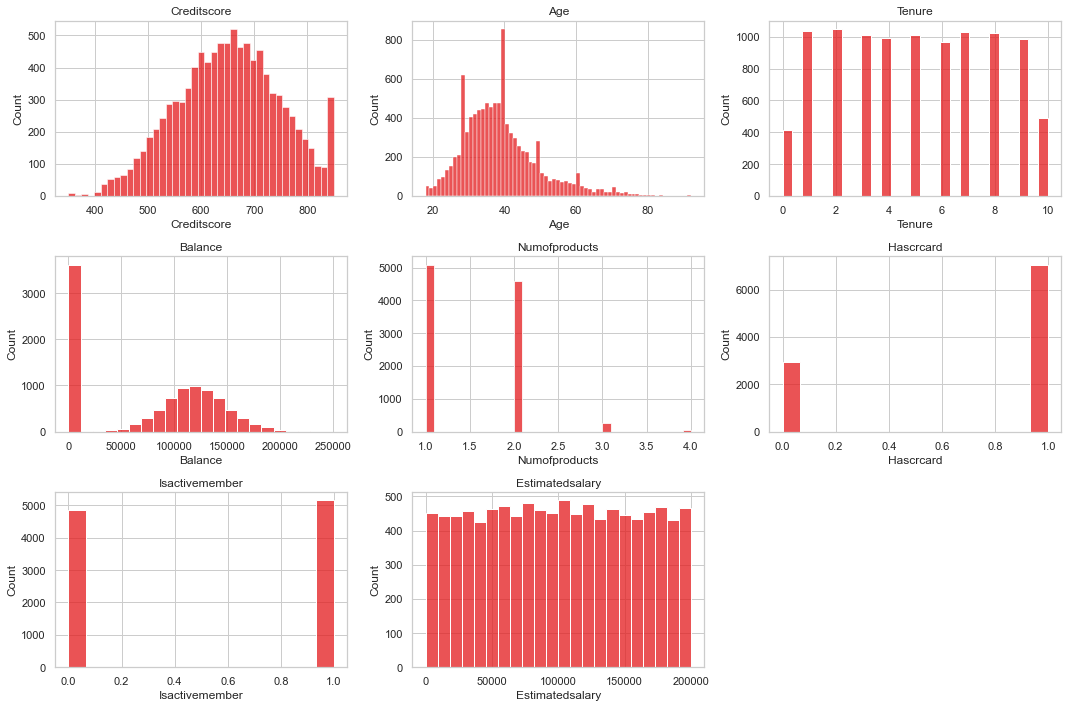

In [13]:
# Plot numerical features distribution
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set1')
plotnumber = 1

for feature in num_features:
    ax = plt.subplot(3, 3, plotnumber)
    sns.histplot(x=feature, data = df)
    plt.xlabel(feature.capitalize())
    plt.title(feature.capitalize())
    plt.tight_layout()
    plotnumber += 1;

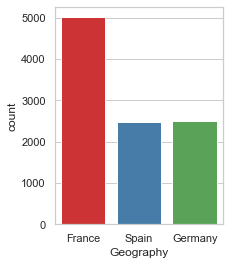

In [14]:
# Which country that most of the customers come from?
plt.figure(figsize=(3, 4))
sns.set_palette('Set1')
sns.countplot(x='Geography', data=df);

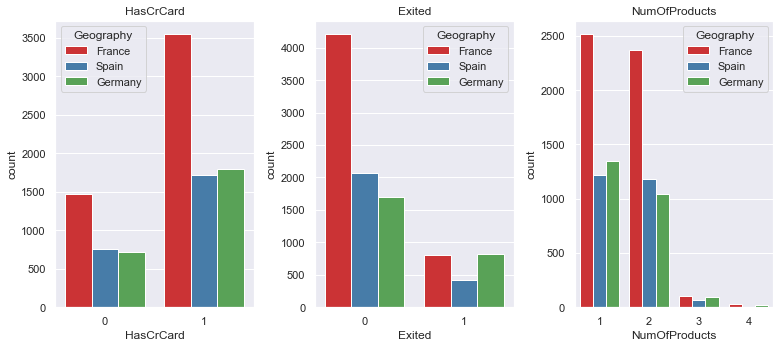

In [15]:
# Plot some features related to the origin of customers
features = ['HasCrCard', 'Exited', 'NumOfProducts']
plt.figure(figsize=(11, 5))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, 3, plotnumber)
    sns.countplot(x=feature, hue='Geography', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

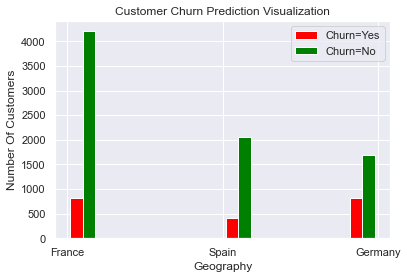

In [16]:
# Which country has the most churn customer?
geo_churn_no = df[df.Exited==0]['Geography']
geo_churn_yes = df[df.Exited==1]['Geography']

plt.xlabel('Geography')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([geo_churn_yes, geo_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

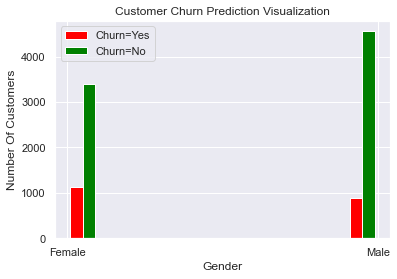

In [17]:
# What gender tends to churn?
gender_churn_no = df[df.Exited==0]['Gender']
gender_churn_yes = df[df.Exited==1]['Gender']

plt.xlabel('Gender')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([gender_churn_yes, gender_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

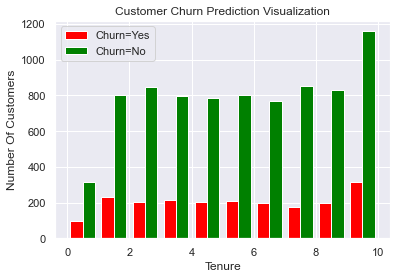

In [18]:
# Is there any relationship between tenure and churn rate?
tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel('Tenure')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

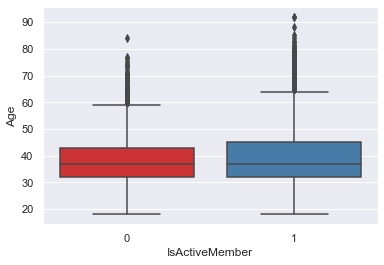

In [19]:
# Distribution of active member and age
sns.boxplot(x='IsActiveMember', y='Age', data=df);

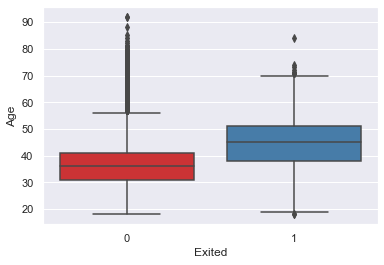

In [20]:
# Distribution of churn and age
sns.boxplot(x='Exited', y='Age', data=df);

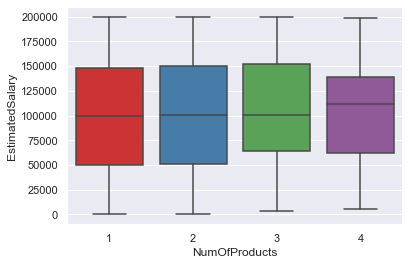

In [21]:
# Is there any particular pattern between estimated salary and number of products used?
sns.boxplot(x='NumOfProducts', y='EstimatedSalary', data=df);

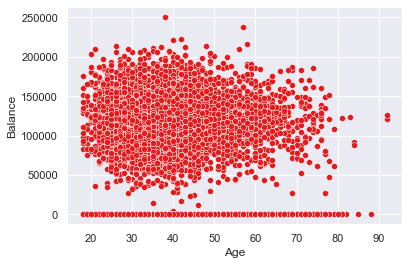

In [22]:
# Is there any particular trend between balance and age?
sns.scatterplot(x='Age', y='Balance', data=df);

### **Modeling**

In [23]:
# Reordering columns
num_features_all = [feature for feature in df.columns if ((df[feature].dtypes != 'O'))]
cols = cat_features + num_features_all
df = df[cols]
df.head()

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,France,Female,619,42,2,0.00,1,1,1,101348.88,1
1,Spain,Female,608,41,1,83807.86,1,0,1,112542.58,0
2,France,Female,502,42,8,159660.80,3,1,0,113931.57,1
3,France,Female,699,39,1,0.00,2,0,0,93826.63,0
4,Spain,Female,850,43,2,125510.82,1,1,1,79084.10,0


**Data splitting**

In [24]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [25]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

**Data preprocessing**

In [26]:
X_train.head(1)

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2151,France,Male,753,57,7,0.0,1,1,0,159475.08


In [27]:
# Transformer schema
onehot = OneHotEncoder(drop='first')

transformer = ColumnTransformer([
    ('onehot', onehot, ['Geography', 'Gender']),
    ('scaler', RobustScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'])
], remainder='passthrough')

### **Model benchmark**

In [28]:
# Define models
logreg = LogisticRegression(random_state=42, max_iter=1000)
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
xgbc = XGBClassifier(random_state=42, verbosity=0)

# Define end-to-end pipeline
models = [logreg, tree, rf, ada, gbc, xgbc]
score = []
mean_score = []
std_score = []

for i in models:
    smotenc = SMOTENC(categorical_features=np.array(range(0, 2)), random_state=42)
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    estimator = imbpipeline([
        ('resampling', smotenc),
        ('preprocessing', transformer),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='recall', error_score='raise', n_jobs=-1)
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

In [29]:
pd.DataFrame({
    'Model':['Logistic Regression', 'Decision Tree', 'Random Forest',' AdaBoost', 'GradientBoosting', 'XGBC'],
    'Recall mean': mean_score,
    'Recall std': std_score
})

,Model,Recall mean,Recall std
0,Logistic Regression,0.588344,0.026487
1,Decision Tree,0.620859,0.029397
2,Random Forest,0.640491,0.043485
3,AdaBoost,0.689571,0.036003
4,GradientBoosting,0.685890,0.029204
5,XGBC,0.644172,0.032924


### **Model Performance on test set**

In [30]:
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

models = [ada, gbc]
score = []

for i in models:
    smotenc = SMOTENC(categorical_features=np.array(range(0, 2)), random_state=42)
    estimator = imbpipeline([
        ('resampling', smotenc),
        ('preprocessing', transformer),
        ('model', i)
    ])

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    score.append([recall_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['Recall score'], index = ['AdaBoost', 'GradientBoosting'])
score_before_tuning

,Recall score
AdaBoost,0.707617
GradientBoosting,0.710074


### **Tuning the model benchmark**

In [31]:
# Hyperparameter space GBC
# Number of trees in GBC
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 12, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Learning rate
learning_rate = [1, 0.1, 0.05, 0.001, 0.005]

hyperparam_space_gbc = {
    'clf_gbc__n_estimators': n_estimators,
    'clf_gbc__max_features': max_features,
    'clf_gbc__max_depth': max_depth,
    'clf_gbc__min_samples_split': min_samples_split,
    'clf_gbc__min_samples_leaf': min_samples_leaf,
    'clf_gbc__learning_rate': learning_rate
}

# Hyperparameter space AdaBoost
# Number of trees in AdaBoost
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 20)]
# Learning rate
learning_rate = [1, 0.1, 0.05, 0.001, 0.005]

hyperparam_space_ada = {
    'clf_ada__n_estimators': n_estimators,
    'clf_ada__learning_rate': learning_rate
}

In [38]:
# Create the algorithm chains
estimator_gbc = imbpipeline([('balancing', smotenc), ('preprocessing', transformer), ('clf_gbc', gbc)])
estimator_ada = imbpipeline([('balancing', smotenc), ('preprocessing', transformer), ('clf_ada', ada)])

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, # model to tune
    param_distributions = hyperparam_space_gbc, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    return_train_score = True,
    n_jobs = -1, # use all cores
    random_state = 42  
)

random_ada = RandomizedSearchCV(
    estimator_ada, # model to tune
    param_distributions = hyperparam_space_ada, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    return_train_score = True, 
    n_jobs = -1 # use all cores
    random_state = 42
)

In [40]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('balancing',
                                              SMOTENC(categorical_features=array([0, 1]),
                                                      random_state=42)),
                                             ('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender']),
                                                                              ('scaler',
                                                                         

In [41]:
random_ada.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('balancing',
                                              SMOTENC(categorical_features=array([0, 1]),
                                                      random_state=42)),
                                             ('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender']),
                                                                              ('scaler',
                                                                         

In [42]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)
print()
print('AdaBoost')
print('Best_score:', random_ada.best_score_)
print('Best_params:', random_ada.best_params_)

GBC
Best_score: 0.6478527607361964
Best_params: {'clf_gbc__n_estimators': 1600, 'clf_gbc__min_samples_split': 5, 'clf_gbc__min_samples_leaf': 2, 'clf_gbc__max_features': 'sqrt', 'clf_gbc__max_depth': 8, 'clf_gbc__learning_rate': 0.005}

AdaBoost
Best_score: 0.7098159509202454
Best_params: {'clf_ada__n_estimators': 200, 'clf_ada__learning_rate': 0.05}


### **Use the best estimator to predict test set**

In [43]:
gbc_tuning = random_gbc.best_estimator_
gbc_tuning.fit(X_train, y_train)

ada_tuning = random_ada.best_estimator_
ada_tuning.fit(X_train, y_train)

y_pred_gbc_tuning = gbc_tuning.predict(X_test)
y_pred_ada_tuning = ada_tuning.predict(X_test)

recall_gbc_tuning = recall_score(y_test, y_pred_gbc_tuning)
recall_ada_tuning = recall_score(y_test, y_pred_ada_tuning)

In [52]:
score_list = [recall_ada_tuning, recall_gbc_tuning]
models = ['AdaBoost', 'GradientBoosting']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'Recall': score_list
})

### **Comparison of the recall scores**

In [51]:
score_before_tuning

,Recall score
AdaBoost,0.707617
GradientBoosting,0.710074


In [53]:
score_after_tuning

,Model,Recall
0,AdaBoost,0.712531
1,GradientBoosting,0.660934


`Confusion matrix`

In [47]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))
print()
print('AdaBoost')
print(classification_report(y_test, y_pred_ada_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1593
           1       0.55      0.66      0.60       407

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000


AdaBoost
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1593
           1       0.47      0.71      0.57       407

    accuracy                           0.78      2000
   macro avg       0.70      0.76      0.71      2000
weighted avg       0.83      0.78      0.80      2000



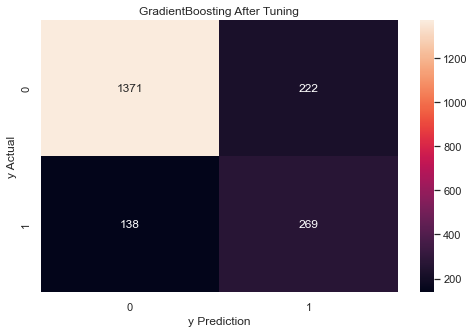

In [48]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediction')
plt.ylabel('y Actual')
plt.title('GradientBoosting After Tuning');

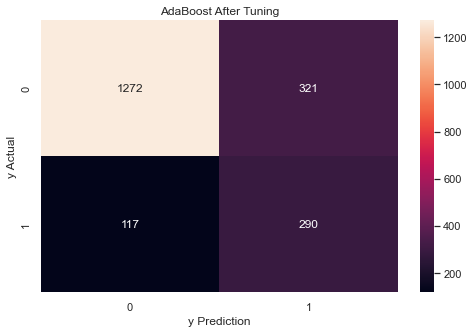

In [49]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_ada_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediction')
plt.ylabel('y Actual')
plt.title('AdaBoost After Tuning');

### **Summary**

As we have tried to tune the best two models, we can see that the result is opposite to each other. Surprisingly, the gradient boosting model has a significant drop in its recall score after we tuned with some hyperparameters. On the other hand, AdaBoost got a slight improvement even though we only tuned the number of estimators and learning rate.

However, there is always a trade-off between recall and precision score with a default threshold. Assume that we only focus on suppressing the number of false negatives and do not mind the number of false positives because false negatives are more costly; then, the AdaBoost is a better choice. The last point to note, there may be other approaches to improve the performance since we only have about 20% of the class positive, e.g., feature engineering, more appropriate hyperparameter values. 